In [24]:
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import torch_geometric.utils
import seaborn as sns



import torch.nn.functional as F
from torch.nn import Linear, Embedding, ModuleList, Sequential, ReLU, Dropout, BatchNorm1d
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import kneighbors_graph

In [25]:
load_dotenv(find_dotenv())

PROJECT_ROOT = Path(find_dotenv()).parent.resolve()
print(f"PROJECT_ROOT set to: {PROJECT_ROOT}")

DATA_DIR = PROJECT_ROOT / 'data'

PROJECT_ROOT set to: C:\Users\rtrin\OneDrive\Escritorio\FORMACIÓN\MÁSTER\TSCD\ProyectoTSCD


# Importación de datos

In [26]:
datos = pd.read_csv(DATA_DIR / 'datos.csv')
datos.set_index('ptnum', inplace=True)

In [27]:
X = datos.drop(columns=['target']).to_numpy(dtype=np.float32)
y = datos['target'].to_numpy(dtype=np.int64)

# Seleccion de nodos y construcción del grafo
Grafo de nodos y aristas construidas mediante el método métrico KNN

In [28]:

k = 5
adj = kneighbors_graph(X, n_neighbors=k, mode='connectivity', include_self=False,metric='euclidean')
coo = adj.tocoo() 
edge_index= torch.stack([torch.tensor(coo.row), torch.tensor(coo.col)], dim=0).long()
edge_index = torch_geometric.utils.to_undirected(edge_index)


c:\Users\rtrin\OneDrive\Escritorio\FORMACIÓN\MÁSTER\TSCD\ProyectoTSCD\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [29]:
edge_index.shape

torch.Size([2, 33724])

Ahora edge_index es nuestra representación de los nodos y aristas del grafo mediante lo que se conoce como una "lista de aristas" (edge list) pero en este caso traspuesta.

Vamos a acabar de darle formato a los datos para poder aplicarle las la GNN.

Pasamos los datos a tensores de PyTorch y los almacenamos en un objeto Data de PyTorch Geometric.

In [30]:
X_torch= torch.tensor(X, dtype=torch.float)
y_torch = torch.tensor(y, dtype=torch.long)
num_nodes = X_torch.size(0)
num_classes = 2

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

In [31]:
indices = torch.randperm(num_nodes)

split_train = int(num_nodes * 0.8) 
split_val = int(num_nodes * 0.9)   

train_mask[indices[:split_train]] = True
val_mask[indices[split_train:split_val]] = True
test_mask[indices[split_val:]] = True

In [32]:
graph_dataset = Data(
    x=X_torch, 
    edge_index=edge_index, 
    y=y_torch,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)

In [33]:
features_type = "native"

if features_type == "random":
  node_features = torch.rand((num_nodes, num_nodes))

if features_type == "one_hot":
  node_features = torch.zeros((num_nodes, num_nodes))
  for i in range(num_nodes):
      node_features[i, i] = 1

if features_type == "native":
  node_features = graph_dataset.x

number_of_features = node_features.shape[1]

In [34]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(number_of_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.softmax(x, dim=1),x

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=16).to(device)
data = graph_dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [36]:
def train():
    model.train()
    optimizer.zero_grad()
    out, emb = model(node_features, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out, emb = model(node_features, data.edge_index)
    pred = out.argmax(dim=1)
    val_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    train_acc = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    return val_acc, train_acc

In [ ]:
for epoch in range(1, 151):
    loss = train()
    res = test()
    val_acc, train_acc = res
    print(f'Epoch: {epoch:03d}, Training Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}')

Epoch: 001, Training Loss: -0.9257, Train Accuracy: 0.9334, Val Accuracy: 0.9078
Epoch: 002, Training Loss: -0.9286, Train Accuracy: 0.9331, Val Accuracy: 0.9078
Epoch: 003, Training Loss: -0.9282, Train Accuracy: 0.9339, Val Accuracy: 0.9102
Epoch: 004, Training Loss: -0.9260, Train Accuracy: 0.9336, Val Accuracy: 0.9102
Epoch: 005, Training Loss: -0.9280, Train Accuracy: 0.9339, Val Accuracy: 0.9102
Epoch: 006, Training Loss: -0.9253, Train Accuracy: 0.9334, Val Accuracy: 0.9125
Epoch: 007, Training Loss: -0.9253, Train Accuracy: 0.9331, Val Accuracy: 0.9125
Epoch: 008, Training Loss: -0.9287, Train Accuracy: 0.9331, Val Accuracy: 0.9125
Epoch: 009, Training Loss: -0.9256, Train Accuracy: 0.9331, Val Accuracy: 0.9125
Epoch: 010, Training Loss: -0.9276, Train Accuracy: 0.9336, Val Accuracy: 0.9102
Epoch: 011, Training Loss: -0.9263, Train Accuracy: 0.9348, Val Accuracy: 0.9125
Epoch: 012, Training Loss: -0.9298, Train Accuracy: 0.9339, Val Accuracy: 0.9125
Epoch: 013, Training Loss: -

¿Por qué obtiene tan buenos resultados?

Gracias a las GNN hemos podido no solo aprovechar los atributos de los nodos, sino también la información estructural del grafo que hemos definido mediante el método KNN. Esto, le ha permitido a los nodos pacientes nutrirse de las características de sus vecinos, es decir, los pacientes más similares a ellos, lo cual ha resultado realmente útil.

In [41]:
model.eval()
out, embeddings = model(node_features, data.edge_index)
embeddings = embeddings.detach().cpu().numpy()
embeddings
var_2d = pd.DataFrame(embeddings, columns=['Dim_1', 'Dim_2'])
y=pd.DataFrame(y, columns=['target'])
df_2d = pd.concat([var_2d, y], axis=1)


<Axes: xlabel='Dim_1', ylabel='Dim_2'>

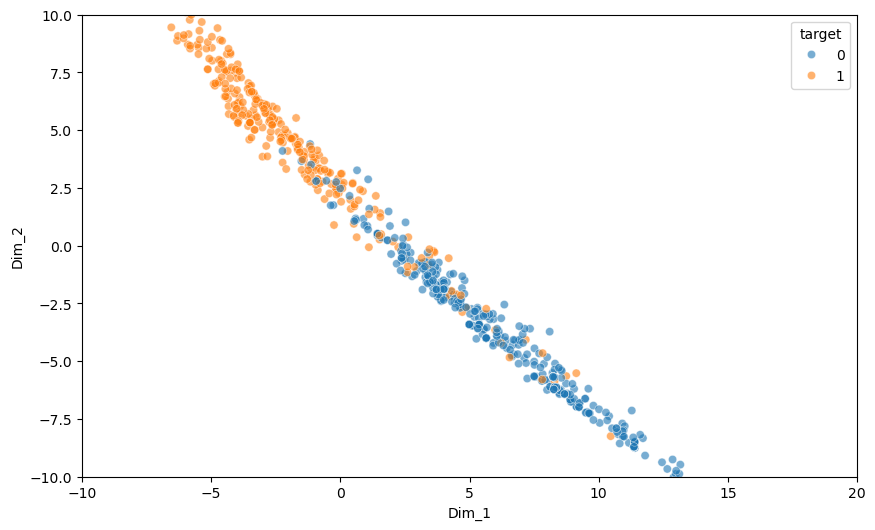

In [44]:
df_sample = df_2d.sample(n=1000, random_state=42) 

plt.figure(figsize=(10, 6))
# Muestra solo desde el valor -10 hasta el 10 en X
plt.xlim(-10, 20) 

# Muestra solo valores positivos en Y
plt.ylim(-10, 10)
sns.scatterplot(
    data=df_sample, 
    x="Dim_1", y="Dim_2",     
    hue='target',  
    alpha=0.6     
)


# Grafo de isntancias

Lo haremos con el conjunto de validación pues son menos nodos y es más sencillo de visualizar.

# Preparamos el grafo para un modelo de aprendizaje profundo

In [40]:
from torch_geometric.utils import from_networkx
data = from_networkx(G)
edge_index_valid= data.edge_index

NameError: name 'G' is not defined

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(number_of_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=16).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)